In [59]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from math import *
import pandas as pd
from functools import partial

In [60]:
def func(x):
    return x**3 - 3 * sin(x)

def deriv1(x):
    return 3*x**2 - 3*cos(x)

def deriv2(x):
    return 6*x + 3 * sin(x)

In [61]:
f = np.vectorize(func)
minimum = scipy.optimize.minimize(f, 1)
minimum.x[0]

0.8241324484434951

In [62]:
minimal_brent = scipy.optimize.brent(func, brack = (0,1), full_output = True)
print(minimal_brent, minimum['x'][0])

(0.8241323111380852, -1.6421304129142098, 10, 13) 0.8241324484434951


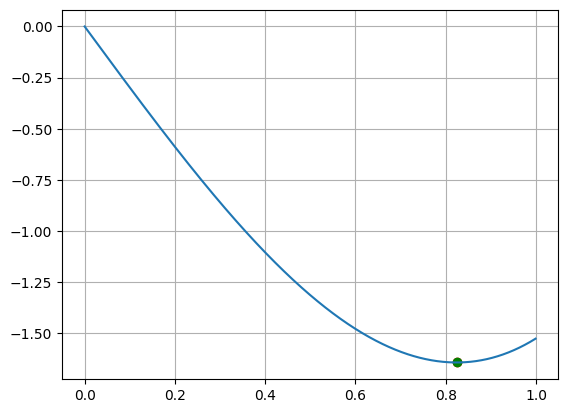

In [63]:
x = np.arange(0, 1, 0.001)
plt.plot(x, f(x))
plt.scatter(minimum['x'], minimum['fun'], color = 'red')
plt.scatter(minimal_brent[0], minimal_brent[1], color = 'green')
plt.grid(True)

In [64]:
def plot_convergence_1d(func, x_steps, y_steps, ax, grid=None, title=""):
    """
    Функция отрисовки шагов градиентного спуска.
    Не меняйте её код без необходимости!
    :param func: функция, которая минимизируется градиентным спуском
    :param x_steps: np.array(float) — шаги алгоритма по оси Ox
    :param y_steps: np.array(float) — шаги алгоритма по оси Оу
    :param ax: холст для отрисовки графика
    :param grid: np.array(float) — точки отрисовки функции func
    :param title: str — заголовок графика
    """
    ax.set_title(title, fontsize=16, fontweight="bold")

    if grid is None:
        grid = np.linspace(np.min(x_steps), np.max(x_steps), 100)

    fgrid = [func(item) for item in grid]
    ax.plot(grid, fgrid)
    yrange = np.max(fgrid) - np.min(fgrid)

    arrow_kwargs = dict(linestyle="--", color="grey", alpha=0.4)
    for i, _ in enumerate(x_steps):
        if i + 1 < len(x_steps):
            ax.arrow(
                x_steps[i], y_steps[i],
                x_steps[i + 1] - x_steps[i],
                y_steps[i + 1] - y_steps[i],
                **arrow_kwargs
            )

    n = len(x_steps)
    color_list = [(i / n, 0, 0, 1 - i / n) for i in range(n)]
    ax.scatter(x_steps, y_steps, c=color_list)
    ax.scatter(x_steps[-1], y_steps[-1], c="red")
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$y$")

In [65]:
class LoggingCallback:
    """
    Класс для логирования шагов градиентного спуска.
    Сохраняет точку (x, f(x)) на каждом шаге.
    Пример использования в коде: callback(x, f(x))
    """
    def __init__(self):
        self.x_steps = []
        self.y_steps = []

    def __call__(self, x, y):
        self.x_steps.append(x)
        self.y_steps.append(y)

In [66]:
def plotting(axes, i, answer, title):
    if axes is not None:
        ax = axes[np.unravel_index(i, shape=axes.shape)]
        x_steps = np.array(callback.x_steps)
        y_steps = np.array(callback.y_steps)
        plot_convergence_1d(
            f, x_steps, y_steps,
            ax, grid, title
        )
        ax.axvline(answer, 0, linestyle="--", c="red",
                    label=f"true answer = {answer}")
        ax.axvline(x_steps[-1], 0, linestyle="--", c="xkcd:tangerine",
                    label=f"estimate = {np.round(x_steps[-1], 3)}")
        ax.legend(fontsize=16)

3 задание

In [67]:
def porazr(fun,a,b,p = 100,eps = 10**-6, callback=None):
    
    if callback is None:
        callback = lambda c, v: 0
    count = 2
    
    h = (b-a)/p
    x = a
    f0 = fun(x)
    f1 = fun(x+h)
    
    callback(x,f0)
    
    x+=h
    while(f1 < f0 and x < b):
#         print(f1,f0, x+h, func(x+h))
        f0 = f1
        callback(x,f0)
        x +=h
        f1 = fun(x)   
        count += 1
    
    h = eps
    f0 = f1
    callback(x,f0)
    x -=h
    f1 = fun(x)
#     print(f0,f1,x)
    
    while(f1 <= f0 and x >= a):
        f0 = f1
        callback(x,f0)
        x -= h
        f1 = fun(x)
        #print(f0,f1, x)
        count +=1
    else:
        return x, count

In [68]:
def polyline_method(f, df, a, b, eps, callback=None):
    
    if callback is None:
        callback = lambda c, v: 0
    
    minf = a
    k,m = 0, 5
    L = 0
    xxx = np.linspace(a,b, 100)
    for x in xxx:
        if abs(df(x))>L:
            L=abs(df(x))
            m+=1
            
#     func_a = f(a)
#     func_b = f(b)
#     p = 0.5 * (func_a + func_b + L * (a - b))
    
    callback(x, func(x))
    
#     d = 1 / 2 / L * (f(x) - p)
    
    while True:
        callback(x, func(x))
        x=(f(a)-f(b)+L*(a+b))/(2*L)
        p=(f(a)+f(b)-L*(a-b))/2
        d =(f(x)-p)/(2*L)
        x1 =x-d
        x2=x+d
        k+=1
        m += 5
        if abs(x2-x1)< eps:
            minf = f(x)
            break
        elif(f(x1)<f(x2)):
            a=x
        else:
            b=x
    callback(x, func(x))
    return x,k,m

In [69]:
def fibonacci_numbers(max_value):

    num1, num2 = 1, 1

    if num1 > max_value:
        return
    
    yield num1

    if num2 > max_value:
        return
    
    yield num2

    while num2 < max_value:
        num1, num2 = num2, num1 + num2
        yield num2

In [70]:
def fibonacci_method(func, a, b, interval_length, eps, callback=None):
    less = True
    if callback is None:
        callback = lambda c, v: 0
        
    max_value = (b - a) / interval_length
    fib = [num for num in fibonacci_numbers(max_value)]
    
    length = len(fib) - 1
    y = a + fib[length - 2] / fib[length] * (b - a)
    z = a + fib[length - 1] / fib[length] * (b - a)
    k = 1
    max_k = length - 3
    
    func_y, func_z = func(y), func(z)
    
    for k in range(max_k + 1):        
        if func_y <= func_z:
            
            less = True
            b, z = z, y
            y = a + fib[length - k - 3] / fib[length - k - 1] * (b - a)
            callback(b, func_z)
        else:
            less = False
            a, y = y, z
            z = a + fib[length - k - 2] / fib[length - k - 1] * (b - a)
            callback(a, func_y)
        func_y, func_z = (func(y), func_y) if less else (func_z, func(z))
        
    y = z
    z = y + eps
    x = (a + z) / 2 if func(y) <= func(z) else (y + b) / 2
    callback(x, func(x))
    return x, max_k + 1

In [71]:
def midpoint_method(func, deriv, a, b, eps, callback=None):
    
    if callback is None:
        callback = lambda c, v: 0
        
    k = 0
    
    interval = b - a
    
    while interval > eps:
        x = (a + b) / 2
        dfunc_x = deriv(x)
        callback(x, func(x))
        if dfunc_x > 0:
            b = x
        else:
            a = x
        interval /= 2
        k += 1
    return x, k

In [72]:
def newton_method(func, dfunc, d2func, x, eps, max_iter=10_000, callback=None, print_info=False):
    
    if callback is None:
        callback = lambda c, v: 0
    
    for k in range(max_iter):
        callback(x, func(x))
        dfunc_x = dfunc(x)
        d2func_x_inv = 1 / d2func(x) 
        d = -d2func_x_inv * dfunc_x
        x_prev = x
        x = x + d
        
        if np.all(abs(x - x_prev) < eps):
            callback(x, func(x))
            return x, k + 1

    if print_info:
        print('Max iterations. Stop')
    callback(x, func(x))
    return x, max_iter

In [73]:
def newton_raphson_method(func, dfunc, d2func, x, eps, lr=1.0,
                          n_eps=0.01, max_iter=10_000,
                          callback=None, print_info=False):
    
    if callback is None:
        callback = lambda c, v: 0
    
    def fi(t, x, d):
        nonlocal func
        return func(x + t * d)

    def dfi(t, x, d):
        nonlocal dfunc
        return dfunc(x + t * d)

    def d2fi(t, x, d):
        nonlocal d2func
        return d2func(x + t * d)
    k = 0
    
    for k in range(max_iter):
        callback(x, func(x))
        dfunc_x = dfunc(x)
        
        d2func_x_inv = 1 / d2func(x)
        d = -d2func_x_inv * dfunc_x 
        fi_x_d = partial(fi, x=x, d=d)
        dfi_x_d = partial(dfi, x=x, d=d)
        d2fi_x_d = partial(d2fi, x=x, d=d)

        t, _ = newton_method(fi_x_d, dfi_x_d, d2fi_x_d, lr, n_eps, max_iter=1)
        x_prev = x
        func_x_prev = func(x)
        x = x + d
        func_x = func(x)
        if np.abs(x - x_prev) < eps:
            callback(x, func(x))
            return x, k + 1

    if print_info:
        print('Max iterations. Stop')
    callback(x, func(x))
    return x, max_iter

In [74]:
porazr(func,0,1,500)

(0.8241309999999469, 2282)

In [75]:
polyline_method(func, deriv1, 0,1,10**-6)

(0.8241326313027102, 19, 101)

In [76]:
iter_number = {'radix_method': [], 'fibonacci_method': [], 'midpoint_method': [], 'newton_raphson_method': [], 'polyline_method': []}
lower_bound = 0
upper_bound = 1
x0 = 0.5
eps = 10**-6
for k in range(1, 6 + 1):
    eps = 10**(-k)
    iter_number['radix_method'].append(porazr(func, lower_bound, upper_bound, 180*2*k, eps)[1])
    iter_number['fibonacci_method'].append(fibonacci_method(func, a=0.1, b=1, interval_length=eps, eps=eps/2)[1])
    iter_number['midpoint_method'].append(midpoint_method(func, deriv1, lower_bound, upper_bound, eps)[1])
    iter_number['newton_raphson_method'].append(newton_raphson_method(func, deriv1, deriv2, x0, eps)[1])
    iter_number['polyline_method'].append(polyline_method(func, deriv1, lower_bound, upper_bound, eps)[1])

In [77]:
# results = pd.DataFrame(iter_number)
# results.T
iter_number

{'radix_method': [299, 595, 893, 1198, 1516, 2187],
 'fibonacci_method': [4, 9, 13, 18, 23, 28],
 'midpoint_method': [4, 7, 10, 14, 17, 20],
 'newton_raphson_method': [2, 3, 4, 4, 5, 5],
 'polyline_method': [3, 6, 9, 12, 16, 19]}

C:\Users\79277\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


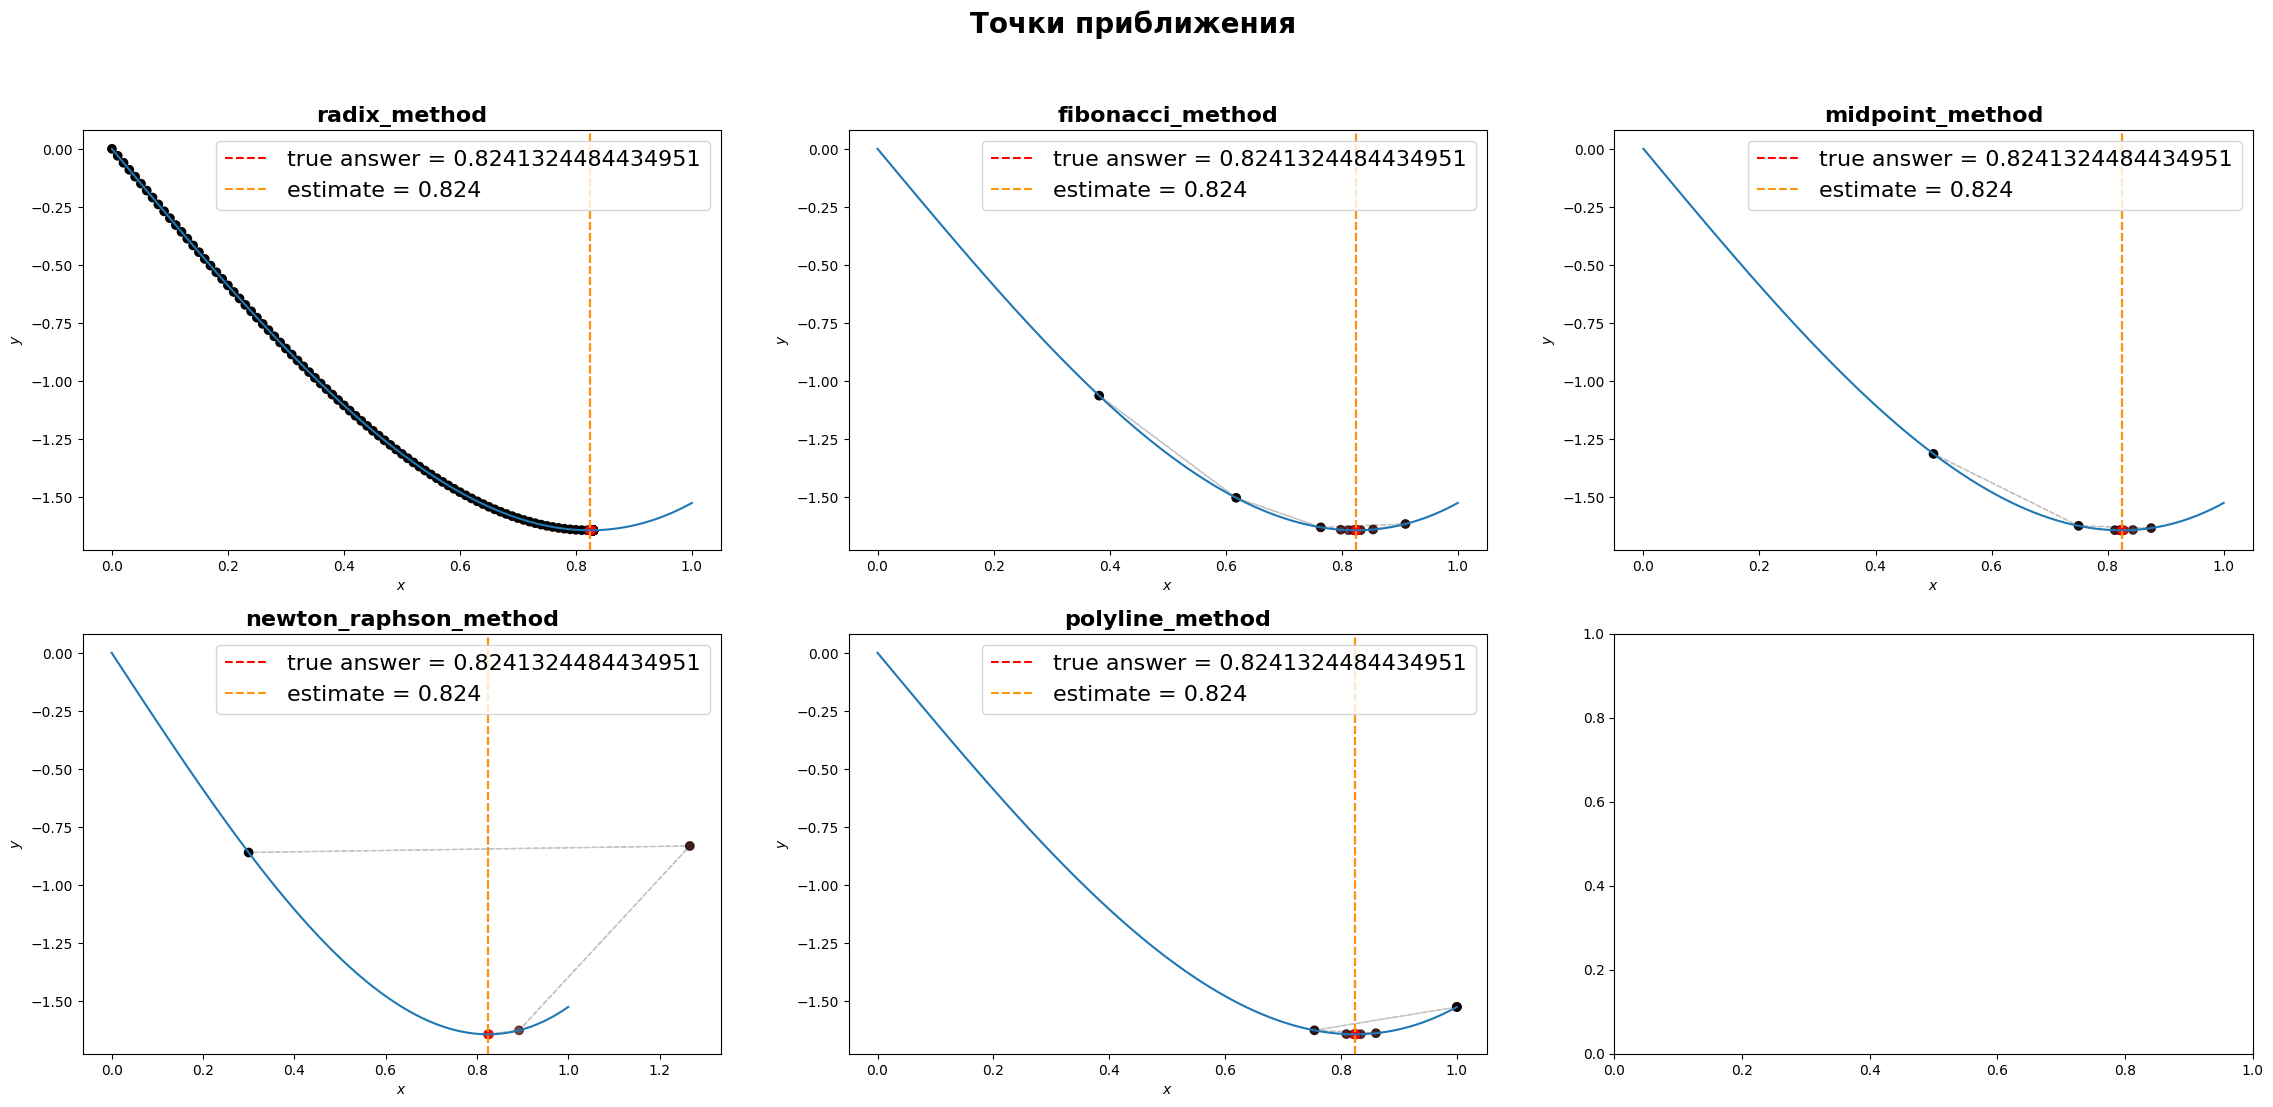

In [82]:
eps = 10**-6
fig, axes = plt.subplots(2,3, figsize=(28, 12))
fig.suptitle("Точки приближения", fontweight="bold", fontsize=20)
grid = np.linspace(lower_bound, upper_bound, 100)


callback = LoggingCallback()  # Не забываем про логирование
porazr(func, lower_bound, upper_bound, 100, eps, callback=callback)
plotting(axes, 0, minimum.x[0],'radix_method')

callback = LoggingCallback()
fibonacci_method(func, lower_bound, upper_bound, interval_length=eps, eps=eps/2, callback=callback)
plotting(axes, 1, minimum.x[0],'fibonacci_method')

callback = LoggingCallback()
midpoint_method(func, deriv1, lower_bound, upper_bound, eps, callback=callback)
plotting(axes, 2, minimum.x[0],'midpoint_method')

callback = LoggingCallback()
newton_raphson_method(func, deriv1, deriv2, 0.3, eps, callback=callback)
plotting(axes, 3, minimum.x[0],'newton_raphson_method')

callback = LoggingCallback()
polyline_method(func, deriv1, lower_bound, upper_bound, eps, callback=callback)
plotting(axes, 4, minimum.x[0],'polyline_method')